# imports

In [1]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import copy
import numpy as np
import os
from display_aux import *
from ships import SHIPS
from df_aux import *
from time_aux import *
from file_aux import *
from plot_aux import *
from parse_aux import *
import sys

In [2]:
ships = SHIPS()


In [3]:
%matplotlib ipympl

In [4]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)


# Run definitions

In [5]:
params = {}
params['input_csv_file_name_full'] = 'C:\\gilad\\work\\tip_and_que\\data\\AIS\\Combined\\Spire_AIS_Combined_All_20231101_1106_000000000000.csv'
# params['input_csv_file_name_full'] = 'debug_data_base.csv'

params['columns_list_keep'] = None
params['filter_vessels_df_dic'] = {
        'max_time_diff[mins]':['<=',30]
        }
params['reload_level'] = 1
params['reload_df_filt'] = False
params['reload_vessels'] = True
params['save_folder_base'] = './pkl'

params['export_to_excel'] = False
params['ana_vessel_name'] = 'EYVAN'
params['ana_vessel_name'] = 'PENG FENG JI'

# params['df_filter_dic'] = {'position_timestamp':['<=','2023-11-01 02:00:00+0000']}
params['df_filter_dic'] = {}

# Load

In [6]:
save_folder = params['save_folder_base']+'/'+ get_file_base_name(params['input_csv_file_name_full'])
df = ships.load_raw_data(params['input_csv_file_name_full'],reload_level=params['reload_level'],save_folder=save_folder)

# filter_df
df = ships.prepare_df(df,reload_level=params['reload_level'],df_filter_dic=params['df_filter_dic'],save_folder=save_folder,columns_list_keep=params['columns_list_keep'])

# data_dic = ships.create_data_dic(df,reload_level=params['reload_level'],save_folder=save_folder)


load_row_data
----------------
load df from ./pkl/Spire_AIS_Combined_All_20231101_1106_000000000000/df_org.pkl
filter_df
----------------
load df from ./pkl/Spire_AIS_Combined_All_20231101_1106_000000000000/df_org.pkl
save df to ./pkl/Spire_AIS_Combined_All_20231101_1106_000000000000/df_filt.pkl


In [7]:
display(df.time.min())
display(df.time.max())

Timestamp('2023-11-01 00:00:00+0000', tz='UTC')

Timestamp('2023-11-01 01:27:53+0000', tz='UTC')

In [8]:
# example
ship_data = ships.get_ship_df(df,'AOS VISION',item_type='name')
params = {'item_type': 'name'}
ship_data = ships.get_ship_df(df,'AOS VISION',**params)
data_stats = ships.get_ship_data_stats(ship_data)
info_df = ships.create_info_df(df, item_type='name',num_lines=1000,id_column_check=['mmsi'])





create item_dic
create info_df
processing name 0 out of 1000


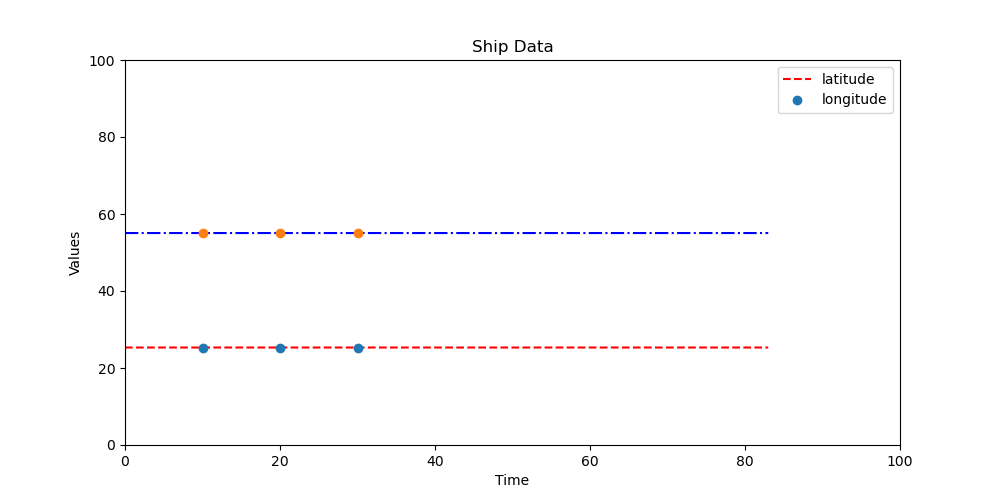

In [9]:
plot_df_columns(ship_data, columns=['latitude', 'longitude'],
 line_styles=['--', '-.'],
  x_label='Time', y_label='Values', legend=True, figsize=(10, 5),
  color=['red', 'blue',],marker_points=[10, 20, 30],
  marker_points_style='o',title='Ship Data',
  xlim=(0, 100), ylim=(0, 100), legend_loc='upper right')


# look at good ones

In [ ]:
def plot_item_columns(df,item,item_type='mmsi',columns=['latitude','longitude'], axes_size=(3, 2), separate_y=True,normalize=False,x_data_type='index',sort_columms = None,pre_process=None,xlim_val =None,ylim_val = None):
    if not isinstance(item, list):
        item = [item]

    if columns is None:
        raise ValueError("columns is empty")
    
    elif not isinstance(columns,list):
        columns = [columns]

    fig, axes = create_subplot_scheme(axes_size=axes_size, num_axes=len(item))

    # Plotting on the created subplots
    for i, ax in enumerate(axes):
        if i > len(item):
            break

        # Assuming 'ships.get_item_df' is a function to filter the DataFrame by item
        df_filt = get_item_df(df, item[i],item_type=item_type,sort_columns=sort_columms)

        if (pre_process=='remove_bias'):
            for column in columns:
                df_filt.loc[:, column] = df_filt[column] - df_filt[column].mean()


        plot_df_columns(df_filt,columns=columns,axes=ax,x_data_type=x_data_type,title=f'{item_type}={item[i]}',xlim_val=xlim_val,ylim_val=ylim_val)
        
        # # Plotting the specified columns
        # for column in columns:
        #     ax.plot(df_filt[column], label=column)
        # ax.set_title(f'MMSI: {mmsi[i]}')
        # ax.legend()

    plt.show()


In [ ]:
item_type = 'name'
control_item_type = 'mmsi'
info_df = info_df.sort_values('span_longitude')

info_df_filter = {'len': ['>',10],
                    f'num_{control_item_type}s':['==',1]}

info_df_filt = filter_df(info_df,info_df_filter)

item = info_df_filt.index[range(16)].tolist()
ylim_val = [-info_df_filt['span_longitude'].max(),info_df_filt['span_longitude'].max()]
plot_item_columns(df,item,item_type=item_type,x_data_type='index',columns=['longitude'],sort_columms=['time_seconds'],pre_process='remove_bias',ylim_val=None)


In [ ]:
import pandas as pd

def normalize_columns(df, columns, method='min-max', add_norm_columns=True):
    """
    Normalize specified columns in a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the columns to be normalized.
    columns (list or str): A list of column names or a single column name to normalize.
    method (str): The normalization method to use ('min-max' or 'z-score').
    add_norm_columns (bool): If True, adds normalized columns with suffix '_norm'. If False, replaces the original columns.

    Returns:
    pd.DataFrame: The DataFrame with normalized columns.
    """
    # Ensure columns is a list
    if isinstance(columns, str):
        columns = [columns]
    
    df_normalized = df.copy()
    
    for column in columns:
        if method == 'min-max':
            norm_col = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
        elif method == 'z-score':
            norm_col = (df[column] - df[column].mean()) / df[column].std()
        else:
            raise ValueError("Method must be 'min-max' or 'z-score'")
        
        if add_norm_columns:
            df_normalized[column + '_norm'] = norm_col
        else:
            df_normalized[column] = norm_col
    
    return df_normalized

# # Sample DataFrame
# data = {
#     'value1': [10, 20, 30, 40, 50],
#     'value2': [5, 15, 25, 35, 45],
#     'value3': [2, 4, 6, 8, 10]
# }
# df = pd.DataFrame(data)

# # Normalize specified columns and add normalized columns
# columns_to_normalize = ['value1', 'value2']
# method = 'min-max'



In [ ]:
from scipy.signal import find_peaks


ship_df = get_item_df(df,params['ana_vessel_name'])
ship_df = normalize_columns(ship_df,columns=['latitude'],method='min-max')

x = np.array(ship_df['latitude'])[1:]
peak_points = find_peaks(x,distance=3)[0]
plot (x,marker_points=peak_points,line_style='-',marker_style='*',marker_points_style='or')
